## Introduction:
This script is designed to analyze and preprocess text data from scraped comments across various online forums. It performs tasks such as cleaning text data, identifying questions, applying TF-IDF vectorization, and generating n-grams. The goal is to provide insights and patterns within the text data for further analysis.

## Required Libraries:
The following Python libraries are used in this script:

- pandas: For data manipulation and analysis.
- better_profanity: For identifying and replacing profanity words (commented out).
- swifter: For accelerating text data processing.
- regex: For working with regular expressions.
- tqdm: For displaying progress bars.
- textblob: For natural language processing tasks.
- nltk: For text processing tasks like tokenization and lemmatization.
- sklearn: For performing TF-IDF vectorization.

## Script Explanation:
1. Reading Dataframes: Reading all the different files and processing them to be concantinated into one dataframe

2. Pre-Processing Data: The pre_process function is defined to clean the text data:

    - Lowercasing text.
    - Identifying questions using specific patterns.
    - Removing usernames and unwanted characters.
    - Lemmatizing words.
    - Removing profanity words .
    - Applying Pre-Processing: The pre_process function is applied to the merged DataFrame to clean the text data.

3. Pie Chart Visualization: A pie chart is created to visualize the distribution of comment types in the merged DataFrame.

4. Saving and Loading Data: The pre-processed DataFrame is saved to a CSV file named "merged.csv" and later read back into a DataFrame for further filter as to skip preprocessing the data everytime the data is to be filtered and analysed

5. Filtering Questions: The DataFrame is filtered to retain only rows with identified questions.

6. Calculating Question Counts per Type: The script calculates the number of questions asked for each comment type in the filtered DataFrame.

7. TF-IDF Vectorization: The tfidf_comments function calculates TF-IDF scores for words in the comments and saves the vocabulary and counts to separate CSV files.

8. Generating n-grams: For the "cancer" forum type, the script generates bigrams from the comments and creates a DataFrame containing counts of different n-grams.

## How to Use:
- Ensure you have the required libraries installed using pip install pandas better_profanity swifter regex tqdm textblob nltk scikit-learn.

- Update the file paths for the CSV files containing scraped data in the script.

- Run the script in a Python environment.

- After execution, the script will generate cleaned data in a DataFrame, perform analysis on question distribution, perform TF-IDF vectorization, and generate n-grams for specific forum types.

- You can explore and analyze the generated outputs for insights and patterns within the text data.

In [33]:
import pandas as pd
from better_profanity import profanity
import swifter
import regex as re
from tqdm.notebook import tqdm
from textblob import TextBlob
from collections import Counter

tqdm.pandas()

In [2]:
pd.set_option('display.max_colwidth', 1)


## Reading the scaraped data

In [5]:
reddit_file = 'Z://Year 2//Programming//DAC//External Project//csvs//Scrapped_Data//reddit.csv'
effective_forum_file = 'Z://Year 2//Programming//DAC//External Project//csvs//Scrapped_Data//effectivealtruism_antidepressants.csv'
cancer_forum_file = 'Z://Year 2//Programming//DAC//External Project//csvs//Scrapped_Data//cancer_research.csv'
anti_depressant_file = 'Z://Year 2//Programming//DAC//External Project//csvs//Scrapped_Data//symptoms_and_withdrawals.csv'

In [6]:
reddit_df = pd.read_csv(reddit_file)
effective_forum_df = pd.read_csv(effective_forum_file)
cancer_forum_df = pd.read_csv(cancer_forum_file)
anti_depressant_df = pd.read_csv(anti_depressant_file)

In [ ]:
anti_depressant_df.head(3)

Processing the anti_depressent scraped data to be esaily merged with the other data

In [7]:
anti_depressant_df['year'] = anti_depressant_df['Date'].str.extract(r'(\d+)$')
anti_depressant_df = anti_depressant_df.query('year >= "2018" & Comment.notnull()')
anti_depressant_df['type'] = 'anti-depressants'

In [ ]:
anti_depressant_df.head(3)

### Merging all the scraped data into 1 dataframe

In [8]:
merged_df = pd.concat([anti_depressant_df[['Comment','type' ]]\
                       .rename(columns={'Comment' : 'comments'}),
                        reddit_df, effective_forum_df , cancer_forum_df ] , 
                       ignore_index=True)

## Pre-Processing data

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
def lemmatize_words(text):
    """custom function to lemmatize the words"""
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(' ')])

In [65]:
def pre_process(dataframe):

    '''
    This Function performs the pre-processing of the dataframe 

    args:
        dataframe: The dataframe to be preprocessed
    
    Functions:
        
        the following are the steps taken to proprocess the data

        1) Lower case tranformation
        2) Creating a column to indicate if the text was a question 
        3) Removing alphabets
        4) Removing WhiteSpace
        5) Removing numeric values
        6) Removing Punctuations
        7) Removing Emojis & other image related symbolds
        8) Lemmatizing the words
        9) Removing Profanity words 
    
    '''
    
    #converts text to lowercase
    dataframe['comments'] = dataframe['comments'].apply(lambda x: x.lower())

    quesion_finidng_patterns =  r'do i|do you|what|who|is it|why|would you|how|is there|' \
                           r'are there|is it so|is this true|to know|is that true|are we|' \
                           r'am i|question is|tell me more|can i|can we|tell me|' \
                           r'can you explain|question|answer|questions|answers|ask|\?'
    


    dataframe['question'] = dataframe['comments'].str.extract(f'({quesion_finidng_patterns})', flags=re.IGNORECASE)

    #Remove usernames  of certain comments
    dataframe['comments'] = dataframe['comments'].str.replace(r"on.+\d+.+\w+\s*said\W", " ")

    #remove single alphabets
    dataframe['comments'] = dataframe['comments'].str.replace(r'[^a-z\s]', ' ')

    #Removes any other whitespace 
    dataframe['comments'] = dataframe['comments'].str.replace(r'\n|\t|\\w|\s', ' ')

    #remove numbers
    dataframe['comments'] = dataframe['comments'].str.replace(r"\d", " ")

    #remove Hyperlinks
    dataframe['comments'] = dataframe['comments'].str.replace(r"<.*?>+|https?://\S+|www\.\S+", " ")
    
    #Remove all punctionations
    dataframe['comments'] = dataframe['comments'].str.replace(r"[^\w\s]|_", " ")

    #Removing Emojis and any other image related symbols
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoji
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
    
    dataframe['comments'] = dataframe['comments'].apply(lambda x: emoji_pattern.sub(r' ', x))

    #Lemmatize the words
    print('Lemmatizing Words')
    dataframe['comments'] = dataframe['comments'].swifter.apply(lemmatize_words) 

    print('Removing Profanity')
    dataframe['comments'] = dataframe['comments'].swifter.apply(profanity.censor)
    dataframe['comments'] = dataframe['comments'].str.replace(r'\*+', ' ')

In [ ]:
#Call Function to pre process the text
pre_process(merged_df)

<Axes: ylabel='type'>

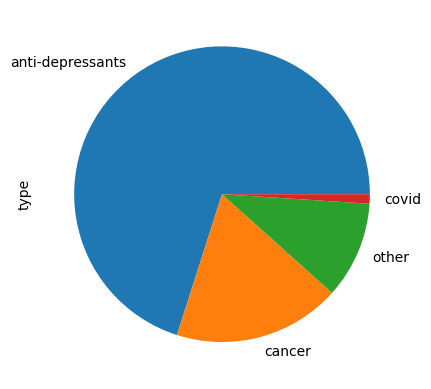

In [13]:
#View the propotition of commment types we have
merged_df.type.value_counts().plot(kind='pie')

In [20]:
merged_df.to_csv('merged.csv',index=False)

In [66]:
merged_df = pd.read_csv('merged.csv')

In [68]:
#return only questions that were asked
comments_questions = merged_df.query('question.notnull()').reset_index(drop=True)

In [69]:
#Number of questions asked per comment type
comments_questions.type.value_counts()

anti-depressants    9643
cancer              1477
other               847 
covid               99  
Name: type, dtype: int64

### Performing TFIDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
def tfidf_comments(forum_types):
    '''
    This function performs TFIDF vectorization on the text and creates a csv file 

    args: 
        forum_types : a list containing the comment types
    
    function: 
        creates csv file containing each unique word and its number of occurances
    '''
    for forum in forum_types:

        #query to obtain a dataframe of the specified type
        df = comments_questions.query('type == @forum ')
        
        tfidf = TfidfVectorizer()
        X= tfidf.fit_transform(df['comments'])

        #Creation of the csv file
        filename = 'csvs//tfidf_'+ forum + '.csv'
        pd.DataFrame(list(tfidf.vocabulary_.items()), columns=['word', 'count']).to_csv(filename , index=False)


In [70]:
cancer_qts = comments_questions.query('type == "cancer"')

In [81]:
def generate_ngrams(text, n):
    words = text.split()
    ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    return ngrams

n = 2
a = cancer_qts['comments'].apply(lambda x : generate_ngrams(x , n))


In [94]:
ngram_counts = dict(Counter([ngram for ngrams in a for ngram in ngrams]))

In [95]:
ngram_counts = pd.DataFrame({'ngrams':ngram_counts})